# 1. Численное решение уравнений

## 1.1 Одномерное уравнение Бюргерса

Рассмотрим физическую модель - уравнение Бюргерса.
Является частным случаем уравнений Навье-Стокса в одномерном случае.
Это простое уравнение, хоть и нелинейное, может описывать течения вязкой жидкости с образованием ударной волны. Является хорошим примером для тестов различных методов решения уравенения. 

В гидродинамике уравнение вводится так: пусть задана скорость течения жидкости $u$ и её кинематическая вязкость 
$\nu$. Тогда в общем виде уравнение Бюргерса записывается так:

$$
    \frac{\partial u}{\partial{t}} + u \frac{\partial u}{\partial x} =
    \nu \frac{\partial^2 u}{\partial x^2}
$$ 


### Загрузка библиотек

Для численного решения уравнения мы воспользуемся библиотекой `phiflow`, в частности будем использовать операторы `numpy` для симуляции течения жидкости: `phi.flow` (дифференцируемая версия _X_ загружается через `phi.X.flow`).

In [1]:
from phi.flow import *

from phi import __version__
print(f"Using phiflow version {phi.__version__}")

Using phiflow version 2.4.0


Теперь мы можем установить некоторые константы. Мы будем использовать разбиение сетки на `N=128` ячеек для моделирования скорости течения жидкости $u$ в одномерном пространстве 1D в области определения $\Omega$ на отрезке $[-1,1]$. Мы будем использовать 32 шага по времени `STEPS` на единичном отрезке, т.е. `DT=1/32`. Вязкость `NU` положим равной $\nu=0.01/\pi$.

Определим начальные условия, соответствующие формуле $-\text{sin}(\pi x)$ в numpy-массиве `INITIAL_NUMPY`, чтобы задать начальные условия для $u$ при моделировании смежных ячеек. Такие начальные условия приведут к формированию шоковых разрывов посредине нашей области определения.



In [2]:
N = 128
DX = 2./N
STEPS = 32
DT = 1./32
NU = 0.01/(N*np.pi)

# задание начальных условий для скоростей в центрах ячеек сетки CenteredGrid, шаг DX/2 offsets для linspace()
INITIAL_NUMPY = np.asarray([-np.sin(np.pi * x) for x in np.linspace(-1+DX/2, 1-DX/2, N)]) # 1D numpy array
INITIAL = math.tensor(INITIAL_NUMPY, spatial('x')) # convert to phiflow tensor

Далее, определим сетку `velocity` из np-массива `INITIAL_NUMPY`, который был преобразован в тензор.
Размерность области определения $\Omega$ определена параметром `bounds`, равным $[-1,1]$, граничные условия 
являются периодическими (`extrapolation.PERIODIC`). Это отличает сетку от тензора: сетка имеет граничные условия и 
физический размер.

Значения сетки содержатся в атрибуте `values`. Функция `numpy()` используется для преобразования тензора в numpy-массив.


In [3]:
velocity = CenteredGrid(INITIAL, extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))
#vt = advect.semi_lagrangian(velocity, velocity, DT)
#velocity = CenteredGrid(lambda x: -math.sin(np.pi * x), extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1)))
#velocity = CenteredGrid(Noise(), extrapolation.PERIODIC, x=N, bounds=Box(x=(-1,1))) # random init

print(f"Velocity tensor shape: {velocity.shape}")
print(f"Velocity tensor type: {type(velocity.values)}")
print(f"Velocity tensor entries 10 to 14: {velocity.values.numpy('x')[10:15]}")

Velocity tensor shape: (xˢ=128)
Velocity tensor type: <class 'phi.math._tensors.NativeTensor'>
Velocity tensor entries 10 to 14: [0.4928982  0.53499764 0.57580817 0.6152316  0.65317285]


### Моделирование

Проведем численное моделирование. Для моделирования диффузионной и адвективной (конвективной) составляющих модели можно воспользоваться операторами `diffusion` и `semi_lagrangian` из библиотеки `phiflow`. 

`diffuse.explicit(u,...)` рассчитывает явный шаг диффузии с помощью центральных разностей для компонента $\nu \frac{\partial^2 u}{\partial x^2}$.

Далее, `advect.semi_lagrangian(f,u)` используется для аппроксимации первой производной произвольного поля `f` по скорости `u`. В нашей модели используется $\partial u / \partial{t} + u \nabla f$, поэтому мы используем `semi_lagrangian` для траснпортировки скорости по отношению к себе:

In [4]:
velocities = [velocity]
age = 0.
for i in range(STEPS):
    v1 = diffuse.explicit(velocities[-1], NU, DT)
    v2 = advect.semi_lagrangian(v1, v1, DT)
    age += DT
    velocities.append(v2)
    
print(f"New velocities content at t={age}: {velocities[-1].values.numpy('x,vector')[0:5]}")

New velocities content at t=1.0: [[0.0057228 ]
 [0.01716715]
 [0.02861034]
 [0.04005201]
 [0.05149214]]


Здесь в списке `velocities` собраны все шаги по времени. 

### Визуализация

На графике синим цветом показано начальное состояние, а затем разными цветами - скорости в моменты времени $10/32, 20/32, 1$.

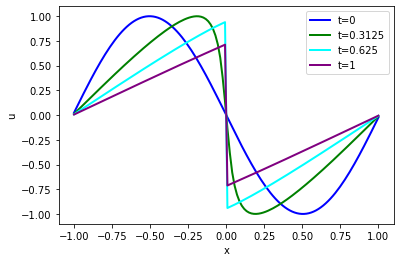

In [5]:
vels = [v.values.numpy('x,vector') for v in velocities]

import pylab

fig = pylab.figure().gca() 
fig.plot(np.linspace(-1, 1, len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color="blue",   label="t=0")
fig.plot(np.linspace(-1, 1, len(vels[10].flatten())), vels[10].flatten(), lw=2, color="green",  label="t=0.3125")
fig.plot(np.linspace(-1, 1, len(vels[20].flatten())), vels[20].flatten(), lw=2, color="cyan",   label="t=0.625")
fig.plot(np.linspace(-1, 1, len(vels[32].flatten())), vels[32].flatten(), lw=2, color="purple", label="t=1")
pylab.xlabel('x'); pylab.ylabel('u'); pylab.legend();

График наглядно демонстрирует процесс возникновения удорного шока посредине области определения, который образуется в результате столкновения двух "ударов" начальной скорости, положительного слева (движущегося вправо) и отрицательного справа от центра (движущегося влево).

Преобразуем наш список состояний скорости в двумерный массив, повторяя отдельные временные шаги 8 раз.
Область определения 1В булет показана вдоль оси Y, а каждая точка вдоль оси X будет показывать один шаг по времени.

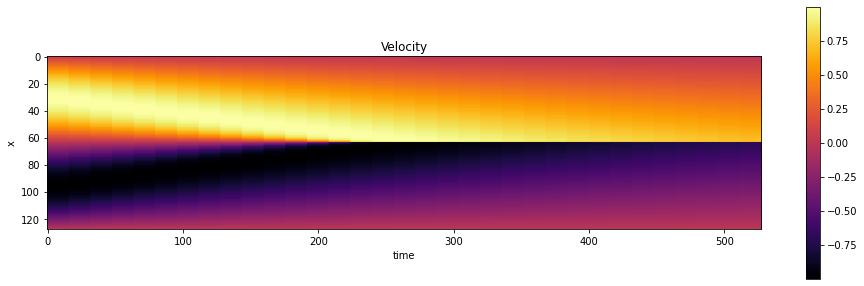

In [6]:
def show_state(a, title):
    a = np.expand_dims(a, axis=2)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=2)
        
    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    pylab.colorbar(im) ; pylab.xlabel('time'); pylab.ylabel('x'); pylab.title(title)
    
vels_img = np.asarray( np.concatenate(vels, axis=-1), dtype=np.float32 ) 

# save for comparison with reconstructions later on
#import os; os.makedirs("./temp",exist_ok=True)
#np.savez_compressed("./temp/burgers-groundtruth-solution.npz", np.reshape(vels_img,[N,STEPS+1])) # remove batch & channel dimension

show_state(vels_img, "Velocity")

## 1.2 Уравнение Навье-Стокса 2D 

Рассмотрим другой пример - моделирование течения жидкости на основе уравнений Навье-Стокса. Все операторы дифференцирования для решения этой задачи содержатся в библиотеке `phiflow`. Уравнения Навье-Стокса (для несжимаемой жидкости) дополнительно содержат поле давлений $p$ и уравнение сохрания массы. Также будем перемещать в потоке маркерное поле, обозначенное через $d$. Оно указывает на области с более высокой температурой и оказывает воздействие с помощью коэффициента плавучести $\xi$:

$$\begin{aligned}
    \frac{\partial \mathbf{u}}{\partial{t}} + \mathbf{u} \cdot \nabla \mathbf{u} &= - \frac{1}{\rho} \nabla p + \nu \nabla\cdot \nabla \mathbf{u} + (0,1)^T \xi d
  \quad \text{при} \quad \nabla \cdot \mathbf{u} = 0,
  \\
  \frac{\partial d}{\partial{t}} + \mathbf{u} \cdot \nabla d &= 0 
\end{aligned}$$

Мы рассматриваем несжимыемую жидкость($\rho = \text{const}$) и исопльзуем простую модель плавучести (аппроксимация Boussinesq) посредством компоненты $(0,1)^T \xi d$. Это аппроксимирует изменения плотности для несжимаемых решателей без явного вычисления $\rho$.Мы предполагаем, что сила тяжести действует вдоль направления y через вектор $(0,1)^T$.
МБудем искать решение этих уравнений в замкнутой области с граничными условиями Дирихле $\mathbf{u}=0$ для скорости, граничными условиями Неймана $\frac{\partial p}{\partial x}=0$ для давления в области $\Omega$ с физическим размером $100 \times 80$.

### Подготовка к моделированию

Будем использовать сетку размером $40 \times 32$ для дискретизации области определения, используя небольшое значение вязкости $\nu$, шаг по времени примем равным $\Delta t=1.5$. Создадим первую сетку `CenteredGrid`, инициализированным через геометрический объект `Sphere`. Это будет соответствовать притоку `INFLOW` горячей области.

In [7]:
DT = 1.5
NU = 0.01

INFLOW = CenteredGrid(
    Sphere(center=tensor([30,15], channel(vector='x,y')), radius=10), 
    extrapolation.BOUNDARY, 
    x=32, 
    y=40, 
    bounds=Box(x=(0,80),y=(0,100))
) * 0.2

Приток будет использоваться для ввода горячего источника во вторую центрированную сетку `smoke`, которая представляет поле маркера $d$. Мы опрееделили область `Box` размером $100 \times 80$. Это физический масштаб в терминах пространственных единиц в нашем моделировании, т.е. скоростьвй $1$ единицу приведет к изменению плотности горячего источника на 1 единицу за 1 единицу времени, что может быть больше или меньше ячейки в дискретизированной сетке, в зависимости от настроек для `x,y`. Можно параметризовать сетку таким образом, чтобы она непосредственно соответствовала единицам измерения в реальном мире, или можно учитывать соответствующие коэффициенты пересчета.

Приведенная сфера уже использует реальные координаты: она расположена на $x=30$ вдоль первой оси и $y=15$ (в пределах области определения $100 \times 80$).

Далее создадим сетки для величин, которые мы хотим смоделировать. Для этого примера нам требуется поле скорости и поле плотности теплового источника.

In [8]:
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled at cell centers
velocity = StaggeredGrid(0, extrapolation.ZERO, x=32, y=40, bounds=Box(x=(0,80),y=(0,100)))  # sampled in staggered form at face centers 

Определим шаг моделирования, который вызывает необходимые функции для моделирования движения нашей жидкостной системы на dt. Следующая ячейка вычисляет один такой шаг и строит график плотности маркеров после одного этапа моделирования.

Max. velocity and mean marker density: [0.1558497, 0.008125]


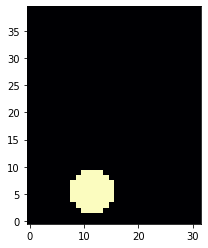

In [9]:
def step(velocity, smoke, pressure, dt=1.0, buoyancy_factor=1.0):
    smoke = advect.semi_lagrangian(smoke, velocity, dt) + INFLOW
    buoyancy_force = (smoke * (0, buoyancy_factor)).at(velocity)  # resamples smoke to velocity sample points
    velocity = advect.semi_lagrangian(velocity, velocity, dt) + dt * buoyancy_force
    velocity = diffuse.explicit(velocity, NU, dt)
    velocity, pressure = fluid.make_incompressible(velocity)
    return velocity, smoke, pressure

velocity, smoke, pressure = step(velocity, smoke, None, dt=DT)

print("Max. velocity and mean marker density: " + format( [ math.max(velocity.values) , math.mean(smoke.values) ] ))

pylab.imshow(np.asarray(smoke.values.numpy('y,x')), origin='lower', cmap='magma');

В шаге `step` мы смоделировали адвекцию (перемещение вдоль пространственных координат) источника, добавили восходящую силу с помощью модели Буссинеска, смоделировали адвекцию поля скоростей, наконец, made it divergence free via a pressure solve.

В модели Бусинека используется множитель `(0, buoyancy_factor)`, чтобы превратить тепловое поле в двухкомпонентное силовое поле, выборка производится в местах расположения компонентов скорости с помощью функции `at()`. Эта функция гарантирует, что отдельные компоненты силы правильно интерполированы для составляющих скорости ступенчатой скорости. Это также непосредственно гарантирует сохранение граничных условий исходной сетки.
Внутри также делается `StaggeredGrid(..., extrapolation.ZERO,...)`.

Шаг прогнозирования давления в `make_incompressible` обычно является самым дорогостоящим с точки зрения вычислений шагом в приведенной выше последовательности. Он решает уравнение Пуассона для граничных условий области и обновляет поле скоростей с учетом градиента вычисленного давления.
На полученном изображении, у нас есть первая круглая область с небольшим движением вверх (которое здесь пока не показано).

Переменные, которые были созданы для моделируемых полей, являются объектами класса `Grid`. Как и тензоры, объекты `Grid` имеют `shape`: $^S$ для пространственной размерности, $^V$ для векторной размерности.

In [10]:
print(f"Smoke: {smoke.shape}")
print(f"Velocity: {velocity.shape}")
print(f"Inflow: {INFLOW.shape}, spatial only: {INFLOW.shape.spatial}")

Smoke: (xˢ=32, yˢ=40)
Velocity: (xˢ=32, yˢ=40, vectorᶜ=x,y)
Inflow: (xˢ=32, yˢ=40), spatial only: (xˢ=32, yˢ=40)


In [11]:
print(f"Shape content: {velocity.shape.sizes}")
print(f"Vector dimension: {velocity.shape.get_size('vector')}")

Shape content: (32, 40, 2)
Vector dimension: 2


Значения в сетке могут быть получены с помощью свойства `values`.

In [12]:
print("Statistics of the different simulation grids:")
print(smoke.values)
print(velocity.values)

# in contrast to a simple tensor:
test_tensor = math.tensor(numpy.zeros([3, 5, 2]), spatial('x,y'), channel(vector="x,y"))
print("Reordered test tensor shape: " + format(test_tensor.numpy('vector,y,x').shape) ) # reorder to vector,y,x 
#print(test_tensor.values.numpy('y,x')) # error! tensors don't return their content via ".values"

Statistics of the different simulation grids:
(xˢ=32, yˢ=40) 0.008 ± 0.039 (0e+00...2e-01)
(xˢ=(x=31, y=32) int64, yˢ=(x=40, y=39) int64, vectorᶜ=x,y) non-uniform
Reordered test tensor shape: (2, 5, 3)


### Моделирование процесса во времени

Тпересь мы можем моделировать процесс во времени с помощью функции `step`.

In [13]:
for time_step in range(10):
    velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
    print('Computed frame {}, max velocity {}'.format(time_step , np.asarray(math.max(velocity.values)) ))

Computed frame 0, max velocity 0.46300098299980164
Computed frame 1, max velocity 0.8966453075408936
Computed frame 2, max velocity 1.4098882675170898
Computed frame 3, max velocity 2.0411267280578613
Computed frame 4, max velocity 2.9279584884643555
Computed frame 5, max velocity 3.8394830226898193
Computed frame 6, max velocity 4.526942729949951
Computed frame 7, max velocity 4.867985725402832
Computed frame 8, max velocity 5.13107967376709
Computed frame 9, max velocity 5.483875274658203


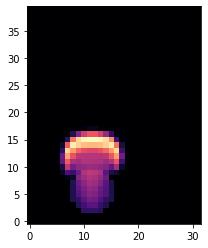

In [14]:
pylab.imshow(smoke.values.numpy('y,x'), origin='lower', cmap='magma')

Так как источник смещен влево от центра, шлейф будет изгибаться вправо, когда он достигнет верхней стенки домена.

Computing time step 0
Computing time step 1
Computing time step 2
Computing time step 10


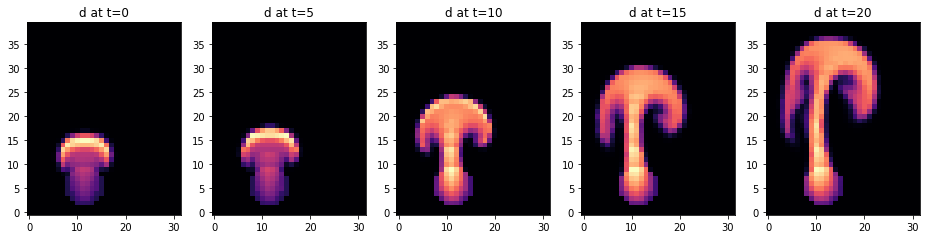

In [15]:
steps = [[ smoke.values, velocity.values.vector[0], velocity.values.vector[1] ]]
for time_step in range(20):
    if time_step<3 or time_step%10==0: 
        print('Computing time step %d' % time_step)
    velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT)
    if time_step%5==0:
        steps.append( [smoke.values, velocity.values.vector[0], velocity.values.vector[1]] )

fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][0].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"d at t={i*5}")

Также можно визуализировать скорости

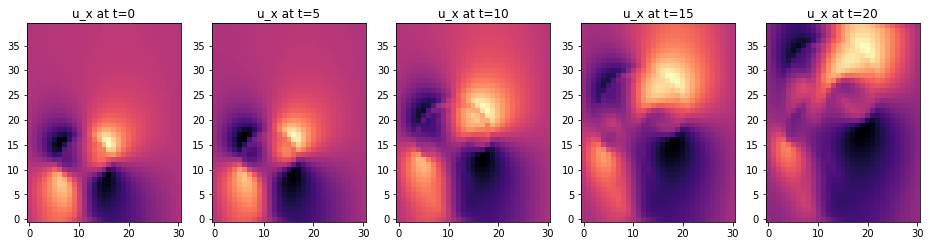

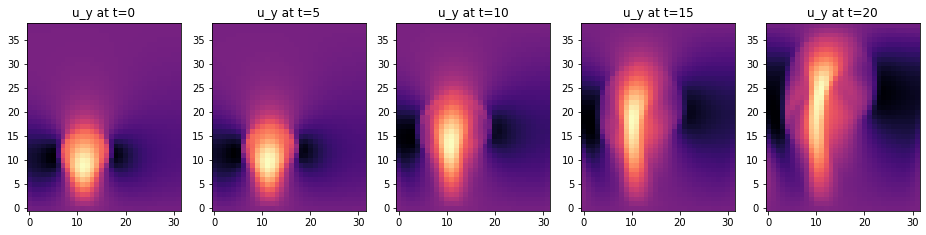

In [16]:
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][1].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"u_x at t={i*5}")
    
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][2].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"u_y at t={i*5}")